# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
import numpy as np
import tensorflow as tf
import IPython.display as display
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import glob
import io
import math
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
# Create a dictionary describing the features
features = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.VarLenFeature(tf.int64),
    'image/width': tf.io.VarLenFeature(tf.int64),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/class/text': tf.io.VarLenFeature(tf.string)
}

In [3]:
def classes(instance):
    classes = instance['image/object/class/label'].values.numpy()
    return classes

In [4]:
def bboxes(instance):
    xmin_list = instance['image/object/bbox/xmin'].values.numpy()
    ymin_list = instance['image/object/bbox/ymin'].values.numpy()
    xmax_list = instance['image/object/bbox/xmax'].values.numpy()
    ymax_list = instance['image/object/bbox/ymax'].values.numpy()
    height = instance['image/height'].values.numpy()
    width = instance['image/width'].values.numpy()

    for i, xmin in enumerate(xmin_list):
        xmin_list[i] = xmin * width
    for i, ymin in enumerate(ymin_list):
        ymin_list[i] = ymin * height
    for i, xmax in enumerate(xmax_list):
        xmax_list[i] = xmax * width
    for i, ymax in enumerate(ymax_list):
        ymax_list[i] = ymax * height
    return xmin_list, ymin_list, xmax_list, ymax_list

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [5]:
def display_images(batch):
    
    colormap = {1: [1, 0, 0], 2: [0, 0, 1], 4: [0, 1, 0]}
    for instance in batch:
        f, ax = plt.subplots(1, figsize=(10,10))
        i = 0
        xmin_list, ymin_list, xmax_list, ymax_list = bboxes(instance)
        
        _classes = classes(instance)
        img = Image.open(io.BytesIO(instance['image/encoded'].numpy()))
        ax.imshow(img)
        for cl in _classes:
            x1 = xmin_list[i]
            y1 = ymin_list[i]
            x2 = xmax_list[i]
            y2 = ymax_list[i]
            rec = Rectangle((x1, y1), x2- x1, y2-y1, facecolor='none', edgecolor=colormap[cl])
            ax.add_patch(rec)
            i+=1  
        ax.axis('off')
    plt.tight_layout()    
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

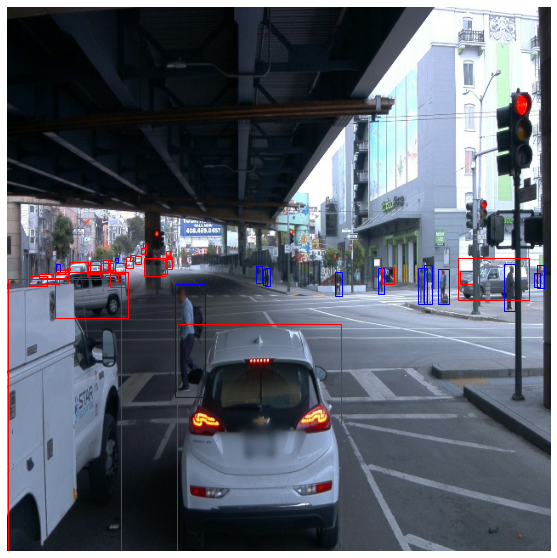

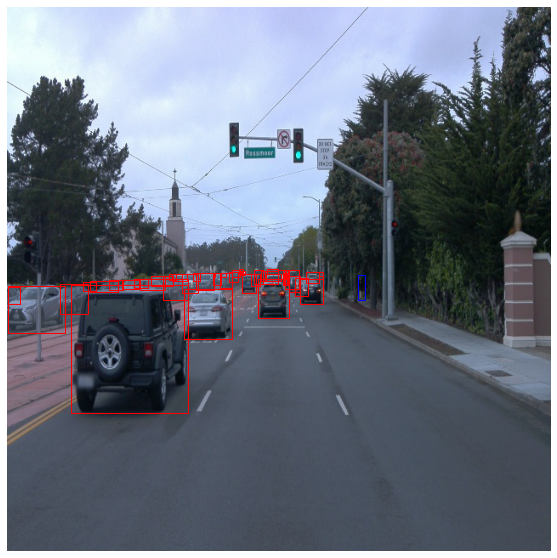

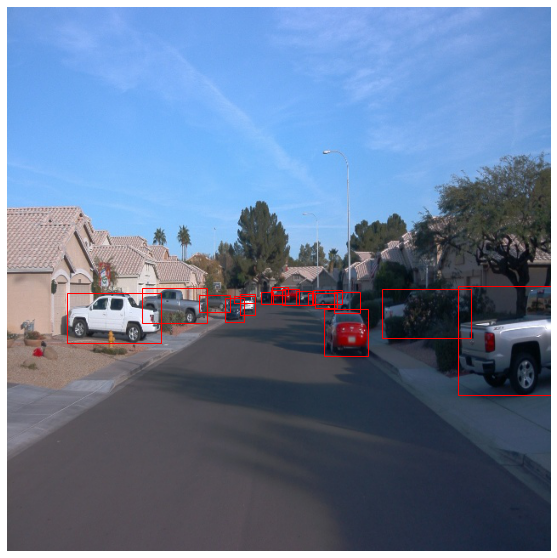

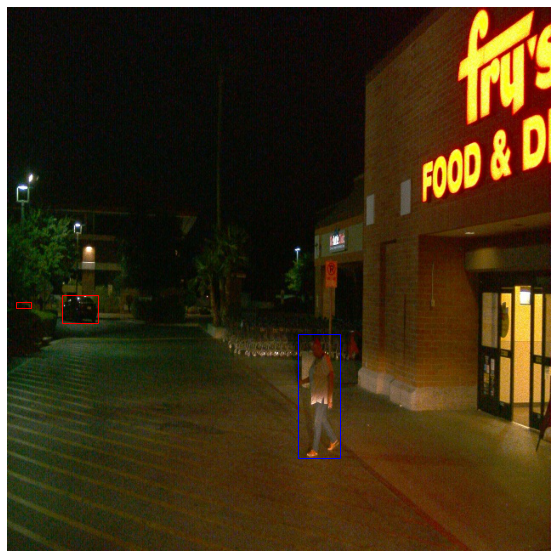

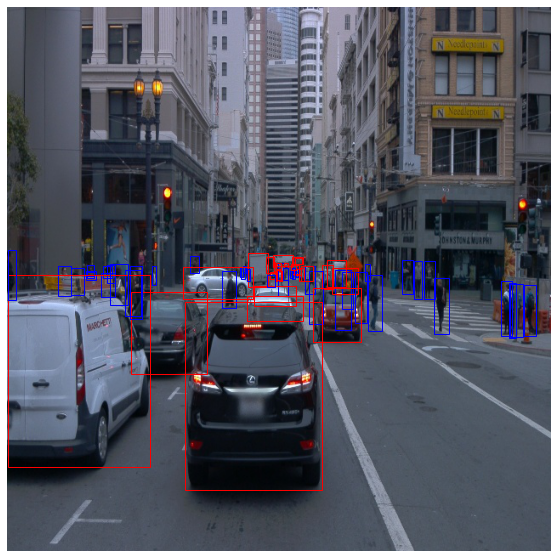

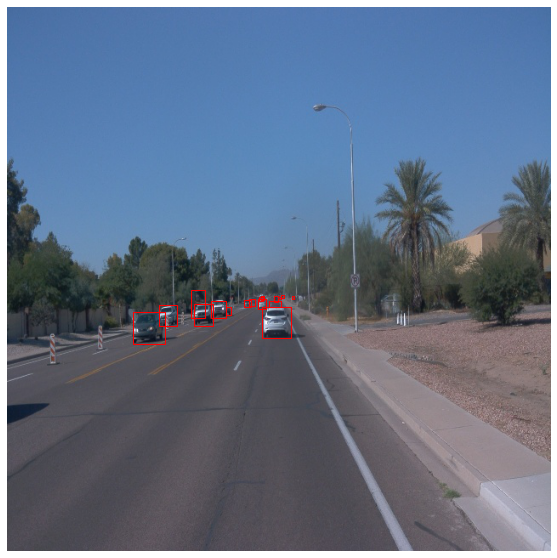

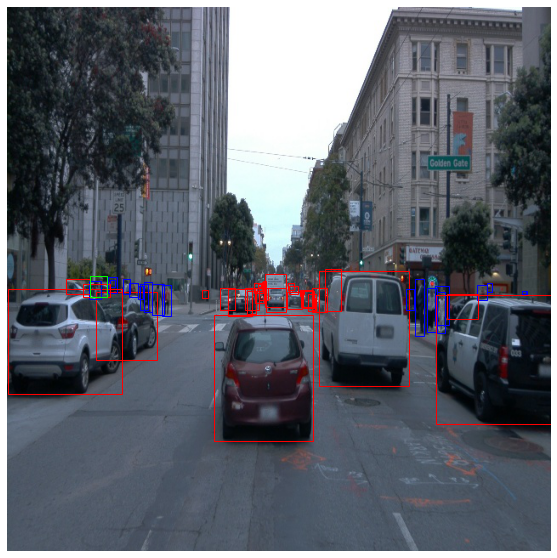

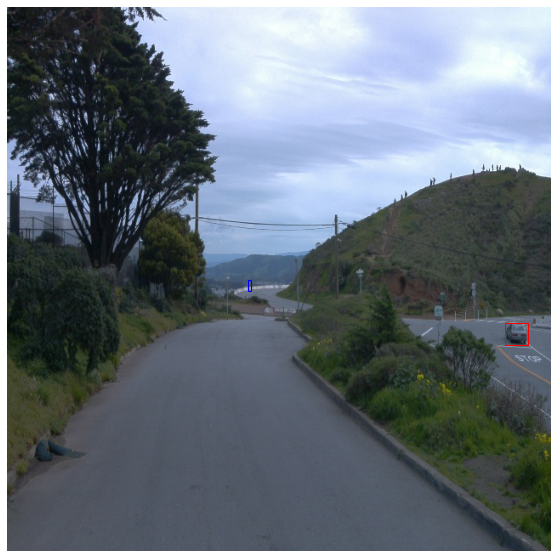

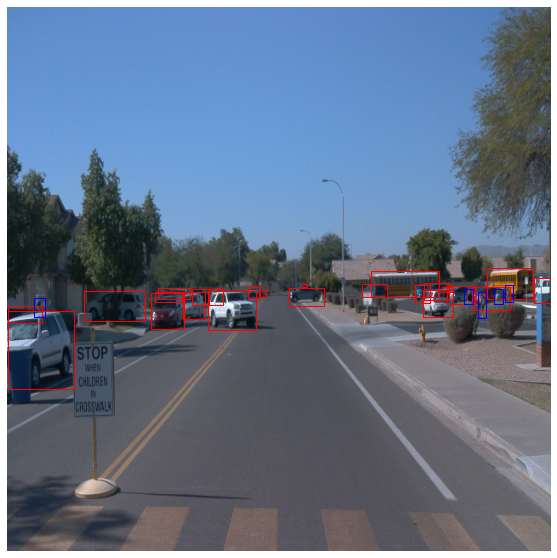

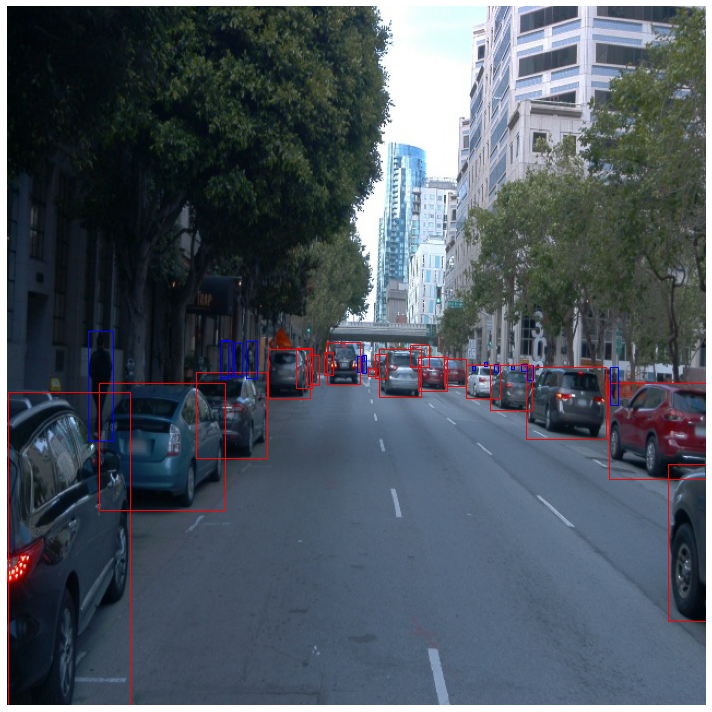

In [6]:
# Display 10 random images in dataset

path = './data/train'
tf_rec_list = glob.glob(path + '/*.tfrecord')
data = tf.data.TFRecordDataset(tf_rec_list)
image_data = data.map(lambda x: tf.io.parse_single_example(x, features))
length = image_data.reduce(0, lambda x,_: x+1).numpy()
image_data = image_data.shuffle(length)
image_data = image_data.take(10)

display_images(image_data)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [7]:
def count(array):
    
    x = 0
    y = 0
    z = 0
    for num in array:
        if num == 1:
            x+=1
        elif num == 2:
            y+=1
        else:
            z+=1
    return x,y,z

In [8]:
path = './data/train'
tf_rec_list = glob.glob(path + '/*.tfrecord')
data = tf.data.TFRecordDataset(tf_rec_list)
image_data = data.map(lambda x: tf.io.parse_single_example(x, features))
length = image_data.reduce(0, lambda x,_: x+1).numpy()

classes=[]
x = 0 #1 cars
y = 0 #2 pedestrians
z = 0 #4 cyclists
for instance in image_data.take(length):
        temp = tf.sparse.to_dense(instance['image/object/class/label']).numpy()
        classes.extend(temp.tolist())  
        
x,y,z = count(classes) 
print("Cars: ", x)
print("Pedestrians: ", y)
print("Cyclists: ", z)

Cars:  29710
Pedestrians:  8355
Cyclists:  214


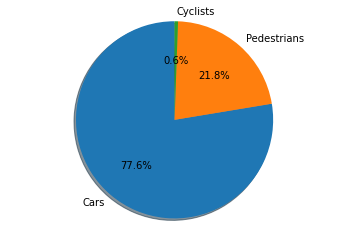

In [9]:
labels = 'Cars', 'Pedestrians', 'Cyclists'
sizes = [x, y, z]
#explode = (0, 0.0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()